In [9]:
# Install required packages (if not already installed)
!pip install gym --quiet

import numpy as np
import pandas as pd
import random
import gym
from gym import spaces
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [32]:
#@title DQN Scalping Agent on BTC-USD with External Data Source using Keras

# ------------------------ External Data Loading -------------------------
# In a real-world system, the following data would be provided from an external source,
# such as a live feed or a database. For demonstration purposes, we simulate external data
# by reading from a CSV file or generating a sample DataFrame.
#
# Example 1: Read from CSV (uncomment and set the file path):
data_row = pd.read_csv('/content/drive/MyDrive/btc_1m_2012-2025-02.01-22.00.csv')
data_row = data_row.rename(columns={'Timestamp': 'date'})
data_row['date'] = pd.to_datetime(data_row['date'], unit='s')
data_row.set_index('date', inplace=True)
# Example 2: Generate sample data (simulating a real feed)
#dates = pd.date_range(start='2023-01-01', periods=300, freq='15T')  # 15-minute frequency
#np.random.seed(42)
#prices = np.cumsum(np.random.randn(300)) + 20000  # simulate a random walk around 20,000
#data = pd.DataFrame({
#    'Open': prices + np.random.randn(300),
#    'High': prices + abs(np.random.randn(300)),
#    'Low': prices - abs(np.random.randn(300)),
#    'Close': prices,
#    'Volume': np.random.randint(10, 100, size=300)
#}, index=dates)
#data.dropna(inplace=True)
# --------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
data=data_row.iloc[6700000:6732280]

In [42]:
initial_data = data

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
#@title ----- Custom Trading Environment that Accepts External 1-Minute Data and Supports Data Updates -----
class BTCScalpingEnv(gym.Env):
    """
    A custom trading environment for BTC-USD that uses external OHLCV data at 1-minute intervals.

    The state includes:
      - current 1m Close price,
      - SMA_short: 5-minute moving average,
      - SMA_1h: 1-hour moving average (60 minutes),
      - SMA_4h: 4-hour moving average (240 minutes).

    Actions:
      0 = Hold, 1 = Buy, 2 = Sell.

    Reward:
      Realized profit on a Sell action (or upon liquidation at the end of the episode).
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, data):
        super(BTCScalpingEnv, self).__init__()
        # Expect data as a DataFrame with columns: Open, High, Low, Close, Volume.
        self.data = data.copy()
        self._recalculate_indicators()

        # Set starting point so that all moving averages are valid.
        self.start_idx = 240  # ensuring SMA_4h (4-hour = 240 minutes) is valid.
        self.current_step = self.start_idx

        # Define action and observation spaces.
        # Actions: 0=Hold, 1=Buy, 2=Sell.
        self.action_space = spaces.Discrete(3)
        # Observation: [current price, SMA_short, SMA_1h, SMA_4h]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(4,), dtype=np.float32)

        # Trading simulation parameters.
        self.initial_balance = 10000.0  # starting capital in USD
        self.balance = self.initial_balance
        self.position = 0.0            # amount of BTC held
        self.entry_price = 0.0         # price at which current position was opened

        # Episode ends when data is exhausted.
        self.max_steps = len(self.data) - 1

    def _recalculate_indicators(self):
        """Recalculate moving averages based on the current data."""
        # 5-minute moving average.
        self.data['SMA_short'] = self.data['Close'].rolling(window=5, min_periods=1).mean()
        # 1-hour moving average (60 minutes).
        self.data['SMA_1h'] = self.data['Close'].rolling(window=60, min_periods=1).mean()
        # 4-hour moving average (240 minutes).
        self.data['SMA_4h'] = self.data['Close'].rolling(window=240, min_periods=1).mean()

    def update_data(self, new_data):
        """
        Append new data to the existing dataset and recalculate the indicators.
        new_data: a DataFrame with the same columns as the original (e.g., Open, High, Low, Close, Volume).
        """
        # Append new data.
        self.data = pd.concat([self.data, new_data])
        self.data.sort_index(inplace=True)
        self._recalculate_indicators()
        self.max_steps = len(self.data) - 1
        print(f"Data updated. New length: {len(self.data)} rows.")

    def reset(self):
        self.current_step = self.start_idx
        self.balance = self.initial_balance
        self.position = 0.0
        self.entry_price = 0.0
        return self._next_observation()

    def _next_observation(self):
        # Get the observation at the current step.
        row = self.data.iloc[self.current_step]
        obs = np.array([
            float(row['Close']),
            float(row['SMA_short']),
            float(row['SMA_1h']),
            float(row['SMA_4h'])
        ])
        return obs.reshape(1, -1)

    def step(self, action):
        reward = 0.0
        done = False
        info = {}

        current_price = float(self.data.iloc[self.current_step]['Close'])

        # Execute action.
        if action == 1:  # Buy
            if self.position == 0:
                self.position = self.balance / current_price
                self.entry_price = current_price
        elif action == 2:  # Sell
            if self.position > 0:
                profit = (current_price - self.entry_price) * self.position
                reward = profit
                self.balance += profit
                self.position = 0.0
                self.entry_price = 0.0

        self.current_step += 1
        if self.current_step >= self.max_steps:
            done = True
            if self.position > 0:
                final_price = float(self.data.iloc[self.current_step]['Close'])
                profit = (final_price - self.entry_price) * self.position
                reward += profit
                self.balance += profit
                self.position = 0.0

        next_state = self._next_observation()
        return next_state, reward, done, info

    def render(self, mode='human'):
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance:.2f}")
        print(f"Position: {self.position:.6f} BTC")
        print(f"Current Price: {float(self.data.iloc[self.current_step]['Close']):.2f}")








In [36]:
#@title ----- DQN Agent Definition -----
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.batch_size = 32
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [37]:
#@title ----- Training the Agent with the Initial 1-Minute Data -----
env = BTCScalpingEnv(initial_data)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

episodes = 5  # For demonstration purposes
reward_history = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0.0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state
    agent.replay()
    reward_history.append(total_reward)
    print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/50, Total Reward: 852.69, Epsilon: 0.99
Episode: 2/50, Total Reward: 2731.62, Epsilon: 0.99
Episode: 3/50, Total Reward: 4341.00, Epsilon: 0.99
Episode: 4/50, Total Reward: 1774.47, Epsilon: 0.98
Episode: 5/50, Total Reward: 570.93, Epsilon: 0.98
Episode: 6/50, Total Reward: 1836.12, Epsilon: 0.97
Episode: 7/50, Total Reward: 2200.76, Epsilon: 0.97
Episode: 8/50, Total Reward: 4126.90, Epsilon: 0.96
Episode: 9/50, Total Reward: 860.91, Epsilon: 0.96
Episode: 10/50, Total Reward: 818.86, Epsilon: 0.95
Episode: 11/50, Total Reward: 1905.82, Epsilon: 0.95
Episode: 12/50, Total Reward: 3510.54, Epsilon: 0.94
Episode: 13/50, Total Reward: 2918.15, Epsilon: 0.94
Episode: 14/50, Total Reward: 3463.14, Epsilon: 0.93
Episode: 15/50, Total Reward: 3307.81, Epsilon: 0.93
Episode: 16/50, Total Reward: 1155.53, Epsilon: 0.92
Episode: 17/50, Total Reward: 2786.37, Epsilon: 0.92
Episode: 18/50, Total Reward: 3707.84, Epsilon: 0.91
Episode: 19/50, Total Reward: 1304.38, Epsilon: 0.91
Episod

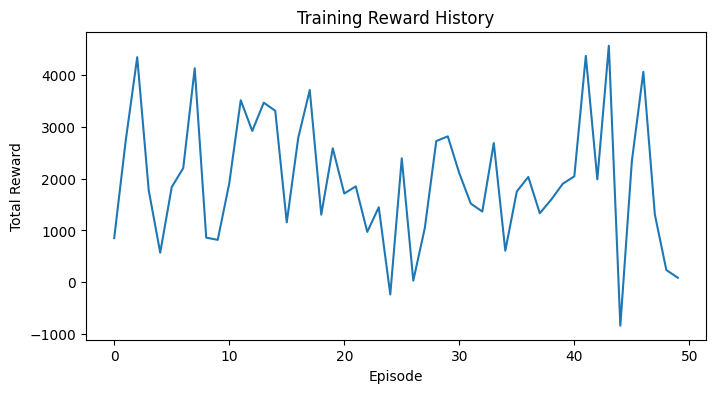

In [38]:
#@title ----- Plotting Reward History -----
plt.figure(figsize=(8,4))
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward History")
plt.show()

In [39]:

#@title ----- Prediction Phase: Output Model Predictions on the Data -----
# Set epsilon to 0 to disable exploration (always pick the best predicted action)
agent.epsilon = 0.0
state = env.reset()

predictions = []
while True:
    # Get Q-values from the network.
    q_values = agent.model.predict(state, verbose=0)[0]
    # Greedy action selection.
    action = np.argmax(q_values)
    # Record prediction details.
    current_row = env.data.iloc[env.current_step]
    predictions.append({
        'step': env.current_step,
        'Close': float(current_row['Close']),
        'SMA_15': float(current_row['SMA_15']),
        'SMA_1h': float(current_row['SMA_1h']),
        'SMA_4h': float(current_row['SMA_4h']),
        'predicted_action': action,
        'q_values': q_values
    })
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

predictions_df = pd.DataFrame(predictions)
print("\n--- Prediction Outputs ---")
print(predictions_df.head())



--- Prediction Outputs ---
   step    Close        SMA_15    SMA_1h      SMA_4h  predicted_action  \
0    16  68689.0  68692.666667  68703.00  68775.6875                 1   
1    17  68707.0  68692.333333  68696.25  68772.6250                 1   
2    18  68674.0  68690.000000  68687.75  68767.8125                 1   
3    19  68673.0  68684.666667  68685.75  68762.2500                 1   
4    20  68649.0  68665.333333  68675.75  68752.4375                 1   

                            q_values  
0  [227.66493, 236.00038, 230.71196]  
1   [228.0254, 235.10878, 232.60307]  
2  [226.99403, 235.12172, 231.01738]  
3    [227.089, 235.35707, 230.95317]  
4     [227.4601, 236.037, 229.81694]  


In [41]:
predictions_df

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,step,Close,SMA_15,SMA_1h,SMA_4h,predicted_action,q_values
0,16,68689.0,68692.666667,68703.00,68775.6875,1,"[227.66493, 236.00038, 230.71196]"
1,17,68707.0,68692.333333,68696.25,68772.6250,1,"[228.0254, 235.10878, 232.60307]"
2,18,68674.0,68690.000000,68687.75,68767.8125,1,"[226.99403, 235.12172, 231.01738]"
3,19,68673.0,68684.666667,68685.75,68762.2500,1,"[227.089, 235.35707, 230.95317]"
4,20,68649.0,68665.333333,68675.75,68752.4375,1,"[227.4601, 236.037, 229.81694]"
...,...,...,...,...,...,...,...
32258,32274,97202.0,97188.666667,97180.00,97083.1875,1,"[309.32617, 337.1327, 324.86285]"
32259,32275,97249.0,97212.333333,97203.75,97093.5000,1,"[309.27588, 337.1471, 326.2574]"
32260,32276,97249.0,97233.333333,97221.50,97105.4375,1,"[308.20312, 337.52356, 324.97394]"
32261,32277,97211.0,97236.333333,97227.75,97117.8750,1,"[307.6018, 338.35144, 321.97858]"


In [ ]:
#@title Optionally, plot the Close price and overlay predicted actions.
plt.figure(figsize=(12, 6))
plt.plot(env.data.index[env.start_idx:env.current_step+1], env.data['Close'].iloc[env.start_idx:env.current_step+1], label='Close Price', color='blue')
buy_signals = predictions_df[predictions_df['predicted_action'] == 1]
sell_signals = predictions_df[predictions_df['predicted_action'] == 2]
plt.scatter(env.data.index[buy_signals['step']], buy_signals['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(env.data.index[sell_signals['step']], sell_signals['Close'], marker='v', color='red', label='Sell Signal')
plt.xlabel("Time")
plt.ylabel("BTC-USD Price")
plt.title("Prediction Outputs: Close Price with Buy/Sell Signals")
plt.legend()
plt.show()


In [ ]:
#@title ----- Simulating New Incoming Data -----
# Here we simulate receiving a new batch of 50 1-minute data points.
new_dates = pd.date_range(start=initial_data.index[-1] + pd.Timedelta(minutes=1), periods=50, freq='1T')
new_prices = np.cumsum(np.random.randn(50)) + initial_data['Close'].iloc[-1]
new_data = pd.DataFrame({
    'Open': new_prices + np.random.randn(50),
    'High': new_prices + abs(np.random.randn(50)),
    'Low': new_prices - abs(np.random.randn(50)),
    'Close': new_prices,
    'Volume': np.random.randint(10, 100, size=50)
}, index=new_dates)
new_data.dropna(inplace=True)

# Update the environment with the new 1-minute data.
env.update_data(new_data)